In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

from typing import Text, Generator, Tuple, List, Optional, Dict, Set
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import json
import re
import uuid
from mpl_toolkits.axes_grid1 import ImageGrid
import math
sns.set_theme()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)

# 1. Load GUI Datasets

In [2]:
data_path = "../data/"
rico_path = "../data/rico/unique_uis/combined/"

In [3]:
all_guis_with_comps = pd.read_csv(data_path + "all_guis.csv")
all_guis_with_comps['data'] = all_guis_with_comps['data'].apply(literal_eval)

In [30]:
def show_images(ranked, img_path, relevances=None):
    fig = plt.figure(figsize=(25,25)) # specifying the overall grid size
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(math.ceil(len(ranked)/3)),3),
                 axes_pad=0.3,  share_all=True
                 )
    if relevances is None:
        relevances = np.zeros(len(ranked))
    for ax, rank, relevance in zip(grid, ranked, relevances):
        rico_id = rank[0]
        img = Image.open(img_path + str(rico_id) + ".jpg")
        img = img.resize((1080, 1920))
        ax.imshow(np.array(img))
        ax.grid(False)
        title = str(rico_id) + ", " + str(round(rank[1], 2))
        if relevance != 0:
            title += ", " + relevance
        ax.title.set_text(title)

    plt.show()

# 2.1 S2W-GUI-Ranker

In [60]:
# Load filters to filter all GUIs that are part of the test set, to avoid being able to retrieve the exact GUIs
dataset_test = pd.read_csv(data_path + 'gui_descriptions/split/' + "dataset_test.csv")
test_set_rico_ids = dataset_test['RICO GUI'].values.tolist()
len(test_set_rico_ids)

100

In [61]:
import torch
from sentence_transformers import SentenceTransformer, util

model_path = data_path + 's2w_ranker/'
with open(model_path + 'index_mapping.pickle', mode='rb') as file:
    index_mapping_s2w = pickle.load(file)
    doc_embeddings = [np.load(model_path + 'embed_s2w_' + str(i) + '.npy') for i in range(0,5)]
    num_docs = len(index_mapping_s2w)
model = SentenceTransformer('all-mpnet-base-v2')

def preprocess_text(text: Text):
    preproc_text = text.lower()
    preproc_text = preproc_text.replace("’", "'")
    preproc_text = preproc_text.replace("“", '"')
    preproc_text = preproc_text.replace("”", '"')
    preproc_text = preproc_text.strip()
    return preproc_text

def rank_s2w(query: Text, rank_threshold: Optional[float] = 0.0,
            rank_cutoff: Optional[int] = 100) -> List[Tuple[int, float]]:
    preproc_query = preprocess_text(query)
    preproc_query_norm = preproc_query
    top_k = compute_ranking(preproc_query_norm, rank_cutoff)
    return top_k

def rank_s2w_filtered(query: Text, rank_threshold: Optional[float] = 0.0,
            rank_cutoff: Optional[int] = 100) -> List[Tuple[int, float]]:
    preproc_query = preprocess_text(query)
    preproc_query_norm = preproc_query
    top_k = compute_ranking(preproc_query_norm, rank_cutoff)
    ranking_sorted_filtered = [(index, conf) for (index, conf) in top_k if not (index in test_set_rico_ids)]
    return ranking_sorted_filtered


def compute_ranking(query: Text, rank_cutoff: int):
    query_embedding = model.encode([query])[0]
    # Initialize cosine scores with zeros
    cos_scores = torch.zeros(num_docs)
    # Compute cosine scores for each embedding matrix and average
    for embed in doc_embeddings:
        curr_cos_scores = util.pytorch_cos_sim(query_embedding, embed)[0]
        cos_scores = curr_cos_scores + cos_scores
    cos_scores = cos_scores / len(doc_embeddings)
    top_k = torch.topk(cos_scores, k=num_docs)
    top_k_results = [index_mapping_s2w[elem] for elem in list(np.array(top_k[1]))]
    top_k_confs = [float(elem) for elem in list(np.array(top_k[0]))]
    return list(zip(top_k_results, top_k_confs))[:rank_cutoff]

def rank_with_json(query: Text, rank_threshold: Optional[float] = 0.0,
            rank_cutoff: Optional[int] = 100):
    ranked_docs = rank_s2w(query, rank_threshold, rank_cutoff)
    return [all_guis_with_comps[all_guis_with_comps['id'] == idd]['data'].values.tolist()[0] for idd, conf in ranked_docs]

[(34503, 0.6118070483207703), (23355, 0.6004642844200134), (53482, 0.5919855833053589), (62332, 0.58563631772995), (27120, 0.5769819021224976), (44818, 0.5718944668769836), (65607, 0.5711914300918579), (47018, 0.5696427226066589), (39746, 0.5635614991188049), (9043, 0.5634466409683228)]


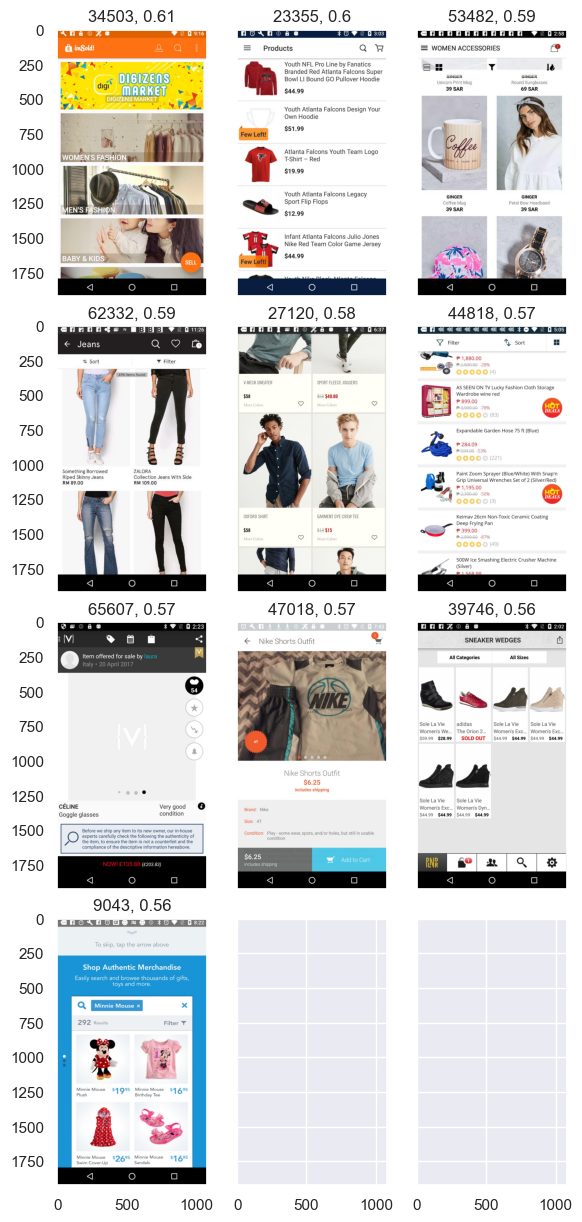

In [7]:
from PIL import Image, ImageDraw, ImageColor

ranked = rank_s2w("A feed of products in a clothing shopping app")[:10]
print(ranked)
show_images(ranked, rico_path)

In [52]:
k = 20

In [190]:
# test set retrieval
df_sample_descriptions_test = pd.read_csv('../data/gui_descriptions/split/dataset_test.csv')

In [191]:
df_sample_descriptions_test = df_sample_descriptions_test.drop(columns=['Av. Ranking', 'Descr'])

In [195]:
df_sample_descriptions_test

,RICO GUI,Descriptions,Length
0,28918,An app made for navigation.,27
1,52757,A page from a recipe app allowing users to search for recipies in different categories,86
2,59109,A page from an App that is a fashion Q&A where others can help one another with different style choices.,104
3,10428,"an organisational app GUI, allowing the user to list the grocerys and save recipes",82
4,66742,"A alarm app GUI, that allows to download and play multiple audios to use as an alarm.",85
5,30144,"A page of an recipe finder, showing pictures of the food",56
6,14854,A weather app GUI that shows the weather forecast for a given city in the following 7 days.,91
7,51979,"The schedule app shows the upcoming matches of a sportsteam. It states the enemy team, where and when the Game will be and shows the logo of each team.",151
8,11579,a page from a language learning app showing common phrases in Spanish and their translations.,93
9,69312,"The GUI from a recipe app, showing a picture and the step by step directions for the dish",89


In [196]:
df_sample_descriptions_test['rico_ranking'] = df_sample_descriptions_test['Descriptions'].apply(lambda x: [rank for rank, conf in rank_s2w_filtered(x)[:k]])

In [197]:
df_sample_descriptions_test[:10]

,RICO GUI,Descriptions,Length,rico_ranking
0,28918,An app made for navigation.,27,"[51024, 40804, 65779, 46769, 28619, 39464, 46771, 15170, 30748, 27316, 42014, 15990, 48836, 68970, 61599, 43326, 48845, 60273, 7007, 18953]"
1,52757,A page from a recipe app allowing users to search for recipies in different categories,86,"[3671, 29116, 23384, 12361, 4792, 59931, 4793, 37173, 15251, 45738, 4781, 204, 70332, 10374, 38660, 25186, 45740, 10373, 6391, 38675]"
2,59109,A page from an App that is a fashion Q&A where others can help one another with different style choices.,104,"[59801, 34503, 31880, 5462, 51890, 53486, 31883, 66963, 40150, 55477, 42120, 15251, 48138, 58089, 21544, 54839, 35833, 4240, 13183, 60823]"
3,10428,"an organisational app GUI, allowing the user to list the grocerys and save recipes",82,"[70332, 20419, 52098, 42040, 38675, 25931, 50386, 10374, 29951, 6391, 21272, 29955, 59911, 25185, 30134, 12361, 70329, 25123, 53724, 38660]"
4,66742,"A alarm app GUI, that allows to download and play multiple audios to use as an alarm.",85,"[25320, 59744, 32234, 1877, 70626, 25307, 59743, 47248, 52571, 61176, 35927, 45210, 5678, 4399, 35925, 57548, 10127, 17903, 70077, 47244]"
5,30144,"A page of an recipe finder, showing pictures of the food",56,"[15251, 12361, 17370, 3671, 10369, 29116, 25185, 19817, 23379, 38660, 59907, 56741, 72168, 70329, 59931, 45738, 37166, 6391, 8167, 23090]"
6,14854,A weather app GUI that shows the weather forecast for a given city in the following 7 days.,91,"[60117, 48751, 21589, 28347, 48742, 28346, 48737, 48756, 11618, 37964, 2894, 28767, 61561, 48740, 42609, 232, 29887, 25250, 8318, 21890]"
7,51979,"The schedule app shows the upcoming matches of a sportsteam. It states the enemy team, where and when the Game will be and shows the logo of each team.",151,"[5482, 20381, 51968, 48247, 68444, 5177, 42251, 44145, 42736, 20376, 56027, 5174, 19834, 361, 57895, 30505, 61612, 61592, 42725, 37033]"
8,11579,a page from a language learning app showing common phrases in Spanish and their translations.,93,"[27731, 45033, 27738, 27729, 52372, 29441, 60912, 27745, 27730, 35612, 63794, 29439, 60921, 52365, 27151, 12092, 60922, 42070, 27742, 59467]"
9,69312,"The GUI from a recipe app, showing a picture and the step by step directions for the dish",89,"[37166, 62610, 62629, 15251, 25185, 59907, 62628, 21272, 30134, 59920, 10374, 38660, 72166, 12361, 8167, 45732, 52091, 37167, 5258, 35915]"
